# Back to the Reddit dataset

After we:

1. Tested few different personality-prediction-by-text tools
2. Generated textual content that highly correlates with high/low openness
3. Trained a logistic regression model to classify texts to high-openness / low-openness
4. Compared the trained model with other models we've trained as well as with the existing tools (1)

We've chose the logistic-regression model that we've trained as the model to work with on the Reddit dataset that we've gathered


## Filter out short texts

To effectively use the model, we need to use only long-enough texts. <br>
We set the threshold as the average length of texts used to train the model, which is **40** tokens.


### Median | AVG Length of posts per community


In [1]:
import os
import json
import statistics

directory = "./data/detailed_filtered_data"
threshold = 40

print(
    "[ Median | AVG ] number of posts left per user after filtering all posts shorter than 40 tokens: "
)
for root, dirs, files in os.walk(directory):
    for folder in dirs:
        counter_in_genre = []
        folder_path = os.path.join(root, folder)
        for file in os.listdir(folder_path):
            if file.endswith(".json"):
                file_path = os.path.join(folder_path, file)
                with open(file_path, "r") as json_file:
                    data = json.load(json_file)
                    counter = 0
                    for community in data.keys():
                        for sub in data.get(community, {}).get("submissions"):
                            if len(sub.get("title", "").split()) >= threshold:
                                counter += 1
                            if len(sub.get("body", "").split()) >= threshold:
                                counter += 1
                        for comment in data.get(community, {}).get("comments"):
                            if len(comment.get("body", "").split()) >= threshold:
                                counter += 1
                    counter_in_genre.append(counter)
        if counter_in_genre:
            print(
                folder,
                "[",
                statistics.median(counter_in_genre),
                "|",
                statistics.mean(counter_in_genre),
                "]",
            )

[ Median | AVG ] number of posts left per user after filtering all posts shorter than 40 tokens: 
indieheads [ 35.0 | 84.467 ]
hiphopheads [ 82.0 | 121.983 ]
Metal [ 53.5 | 103.118 ]
electronicmusic [ 43.0 | 97.761 ]
classicalmusic [ 117.0 | 172.252 ]


### Process the data as a DataFrame


In [2]:
import pandas as pd
import os
import json
from tqdm import tqdm

df = pd.DataFrame(columns=["community", "user_name", "user_texts", "#_of_long_texts"])


def process_files(community, df):
    threshold = 40
    directory = f"./data/detailed_filtered_data/{community}"
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".json"):
            user_texts = []
            with open(os.path.join(directory, filename), "r") as f:
                data = json.load(f)
                for key in data:
                    for submission in data[key].get("submissions", []):
                        title = submission.get("title", "")
                        body = submission.get("body", "")
                        if len(title.split()) >= threshold:
                            user_texts.append(title)
                        if len(body.split()) >= threshold:
                            user_texts.append(body)
                    for submission in data[key].get("comments", []):
                        body = submission.get("body", "")
                        if len(body.split()) >= threshold:
                            user_texts.append(body)
            if len(user_texts) == 0:
                continue
            user_name = filename.split(".json")[0]
            new_row = pd.DataFrame(
                {
                    "community": community,
                    "user_name": [user_name],
                    "user_texts": [user_texts],
                    "#_of_long_texts": [len(user_texts)],
                }
            )
            df = pd.concat([df, new_row], ignore_index=True)
    return df


communities = [
    "classicalmusic",
    "electronicmusic",
    "hiphopheads",
    "indieheads",
    "Metal",
]

for community in communities:
    df = pd.concat([df, process_files(community, df)])
print("Done processing texts :)")

100%|██████████| 1000/1000 [00:01<00:00, 880.59it/s]

Done processing texts :)


#### De-Duplication


In [3]:
def deduplicate_texts(df):
    exploded_df = df.explode("user_texts")
    exploded_df = exploded_df.drop_duplicates(subset="user_texts")
    return exploded_df


df = deduplicate_texts(df)
print("After dedeuplication there are", format(len(df), ","), "unique texts in total")

After dedeuplication there are 575,816 unique texts in total


In [4]:
classicalmusic_df = df[df["community"] == "classicalmusic"]
electronicmusic_df = df[df["community"] == "electronicmusic"]
hiphopheads_df = df[df["community"] == "hiphopheads"]
indieheads_df = df[df["community"] == "indieheads"]
metal_df = df[df["community"] == "Metal"]

print(
    "Number of texts left after deduplication per community:",
    "\nClassicalmusic:",
    format(len(classicalmusic_df), ","),
    "\nElectronicmusic:",
    format(len(electronicmusic_df), ","),
    "\nHiphopheads:",
    format(len(hiphopheads_df), ","),
    "\nIndieheads:",
    format(len(indieheads_df), ","),
    "\nMetal:",
    format(len(metal_df), ","),
)

Number of texts left after deduplication per community: 
Classicalmusic: 170,251 
Electronicmusic: 97,063 
Hiphopheads: 121,538 
Indieheads: 84,314 
Metal: 102,650


In [5]:
classicalmusic_counts = classicalmusic_df["user_name"].value_counts()
electronicmusic_counts = electronicmusic_df["user_name"].value_counts()
hiphopheads_counts = hiphopheads_df["user_name"].value_counts()
indieheads_counts = indieheads_df["user_name"].value_counts()
metal_counts = metal_df["user_name"].value_counts()


print("Median and Mean of texts-count per user in each community after deduplication:")
print(
    "classicalmusic: Median =",
    classicalmusic_counts.median(),
    " | Mean =",
    round(classicalmusic_counts.mean(), 2),
)
print(
    "electronicmusic: Median =",
    electronicmusic_counts.median(),
    " | Mean =",
    round(electronicmusic_counts.mean(), 2),
)
print(
    "hiphopheads: Median =",
    hiphopheads_counts.median(),
    " | Mean =",
    round(hiphopheads_counts.mean(), 2),
)
print(
    "indieheads: Median =",
    indieheads_counts.median(),
    " | Mean =",
    round(indieheads_counts.mean(), 2),
)
print(
    "metal: Median =", metal_counts.median(), " | Mean =", round(metal_counts.mean(), 2)
)

Median and Mean of texts-count per user in each community after deduplication:
classicalmusic: Median = 118.5  | Mean = 173.37
electronicmusic: Median = 60.5  | Mean = 109.55
hiphopheads: Median = 83.0  | Mean = 122.39
indieheads: Median = 52.0  | Mean = 96.8
metal: Median = 58.0  | Mean = 107.94


# Vectorize all Redditors texts


In [6]:
from sentence_transformers import SentenceTransformer
from typing import List, Union
from torch import Tensor
from numpy import ndarray

# MODEL = "intfloat/e5-large-v2" # Larger, and much slower sentence transformer model
MODEL = "all-MiniLM-L6-v2"  # Smaller, and faster sentence transformer model
model = SentenceTransformer(MODEL)


def vectorize_text(
    text, batch_size=12, show_progress_bar=False
) -> Union[List[Tensor], ndarray, Tensor]:
    return model.encode(
        text, show_progress_bar=show_progress_bar, batch_size=batch_size
    )

/Users/eliran/Personal/dev/Musical-Preferences-And-Textual-Expression/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
df = df.reset_index(drop=True)
df.head()

,community,user_name,user_texts,#_of_long_texts
0,classicalmusic,Radaxen,I remember doing this with WC3 Dota 1 Lifestea...,339
1,classicalmusic,Radaxen,Why not? Though there's no AD in League. I ki...,339
2,classicalmusic,Radaxen,"Haha I was kind of joking. That aside, why mos...",339
3,classicalmusic,Radaxen,"Mana is often a less limiting factor, unless y...",339
4,classicalmusic,Radaxen,"It's first pick worthy, but late in first phas...",339


In [8]:
from tqdm import tqdm

tqdm.pandas()

df["vector"] = df["user_texts"].progress_apply(
    lambda x: vectorize_text(x) if not isinstance(x, float) else []
)

100%|██████████| 575816/575816 [2:13:16<00:00, 72.01it/s]  


# Load our logistic regression model


In [9]:
import pickle
from sklearn.linear_model import LogisticRegression

with open("models/mini_gpt_and_myPersonality.pkl", "rb") as f:
    gpt_and_myPersonality: LogisticRegression = pickle.load(f)

### Use the model to Predict-Probablily for every user texts to be in high vs low openness classes


In [10]:
df["OPN_proba"] = df["vector"].progress_apply(
    lambda x: gpt_and_myPersonality.predict_proba(x.reshape(1, -1))
)

100%|██████████| 575816/575816 [00:17<00:00, 32076.31it/s]


In [11]:
df.groupby("community").head(5)

,community,user_name,user_texts,#_of_long_texts,vector,OPN_proba
0,classicalmusic,Radaxen,I remember doing this with WC3 Dota 1 Lifestea...,339,"[-0.09979952, 0.07815618, -0.006864944, 0.0918...","[[0.7617520430655333, 0.23824795693446665]]"
1,classicalmusic,Radaxen,Why not? Though there's no AD in League. I ki...,339,"[-0.061279267, -0.03195634, -0.028046045, -0.0...","[[0.8164201826164899, 0.1835798173835101]]"
2,classicalmusic,Radaxen,"Haha I was kind of joking. That aside, why mos...",339,"[-0.044217307, 0.05339438, -0.04739361, -0.068...","[[0.7133868303206266, 0.28661316967937345]]"
3,classicalmusic,Radaxen,"Mana is often a less limiting factor, unless y...",339,"[0.006160024, -0.015307949, -0.02807415, -0.03...","[[0.6732404176899773, 0.32675958231002267]]"
4,classicalmusic,Radaxen,"It's first pick worthy, but late in first phas...",339,"[-0.039119493, -0.023535224, -0.049316537, -0....","[[0.7115636906252298, 0.2884363093747701]]"
170251,electronicmusic,headphase,"This Monday, June 12, r/BedStuy will become un...",305,"[-0.12748332, -0.06322446, 0.032894388, -0.024...","[[0.6951957114108892, 0.3048042885891108]]"
170252,electronicmusic,headphase,Rant incoming.. I know this isn't just a BedSt...,305,"[0.035946596, -0.045130994, 0.022525277, 0.007...","[[0.7445997549431307, 0.2554002450568693]]"
170253,electronicmusic,headphase,"Hi everyone, first off thanks for your patienc...",305,"[-0.08553691, -0.038916588, 0.048263624, 0.011...","[[0.6576670671884857, 0.3423329328115144]]"
170254,electronicmusic,headphase,"Next Monday, June 12th, r/aviationmemes will b...",305,"[-0.08884483, -0.05682208, 0.061177127, -0.013...","[[0.7379181455706556, 0.26208185442934445]]"
170255,electronicmusic,headphase,"Hi all, as of today a new post flair labeled \...",305,"[0.011248732, 0.030596228, 0.007028569, -0.056...","[[0.573032851951242, 0.426967148048758]]"


### Calculate the average predicted probability for every user's openness classes (high vs low openness)


In [12]:
average_opn_proba_0 = df.groupby("user_name")["OPN_proba"].apply(
    lambda x: x.apply(lambda y: y[0][0]).mean()
)
average_opn_proba_1 = df.groupby("user_name")["OPN_proba"].apply(
    lambda x: x.apply(lambda y: y[0][1]).mean()
)
df["average_opn_proba_0"] = df["user_name"].map(average_opn_proba_0)
df["average_opn_proba_1"] = df["user_name"].map(average_opn_proba_1)

In [13]:
df.head()

,community,user_name,user_texts,#_of_long_texts,vector,OPN_proba,average_opn_proba_0,average_opn_proba_1
0,classicalmusic,Radaxen,I remember doing this with WC3 Dota 1 Lifestea...,339,"[-0.09979952, 0.07815618, -0.006864944, 0.0918...","[[0.7617520430655333, 0.23824795693446665]]",0.707808,0.292192
1,classicalmusic,Radaxen,Why not? Though there's no AD in League. I ki...,339,"[-0.061279267, -0.03195634, -0.028046045, -0.0...","[[0.8164201826164899, 0.1835798173835101]]",0.707808,0.292192
2,classicalmusic,Radaxen,"Haha I was kind of joking. That aside, why mos...",339,"[-0.044217307, 0.05339438, -0.04739361, -0.068...","[[0.7133868303206266, 0.28661316967937345]]",0.707808,0.292192
3,classicalmusic,Radaxen,"Mana is often a less limiting factor, unless y...",339,"[0.006160024, -0.015307949, -0.02807415, -0.03...","[[0.6732404176899773, 0.32675958231002267]]",0.707808,0.292192
4,classicalmusic,Radaxen,"It's first pick worthy, but late in first phas...",339,"[-0.039119493, -0.023535224, -0.049316537, -0....","[[0.7115636906252298, 0.2884363093747701]]",0.707808,0.292192


In [15]:
mean_values = df.groupby("community")[
    ["average_opn_proba_0", "average_opn_proba_1"]
].mean()
median_values = df.groupby("community")[
    ["average_opn_proba_0", "average_opn_proba_1"]
].median()

print("Mean values:")
print(mean_values)

print("\nMedian values:")
print(median_values)

Mean values:
                 average_opn_proba_0  average_opn_proba_1
community                                                
Metal                       0.688614             0.311386
classicalmusic              0.716958             0.283042
electronicmusic             0.684451             0.315549
hiphopheads                 0.681755             0.318245
indieheads                  0.689712             0.310288

Median values:
                 average_opn_proba_0  average_opn_proba_1
community                                                
Metal                       0.688207             0.311793
classicalmusic              0.713479             0.286521
electronicmusic             0.682555             0.317445
hiphopheads                 0.680303             0.319697
indieheads                  0.688481             0.311519


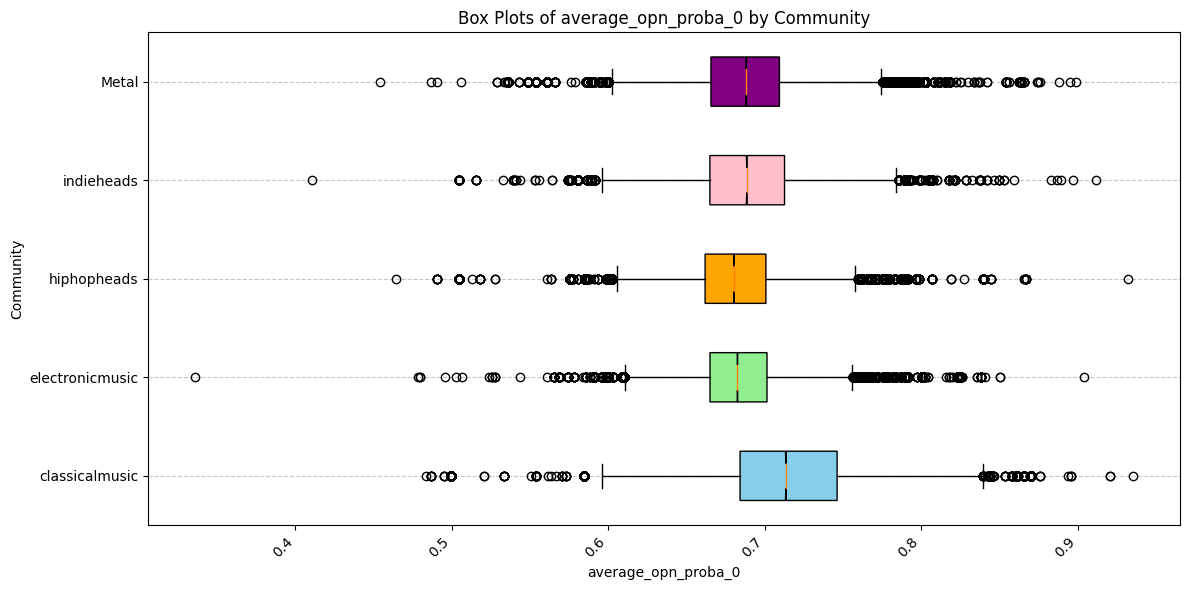

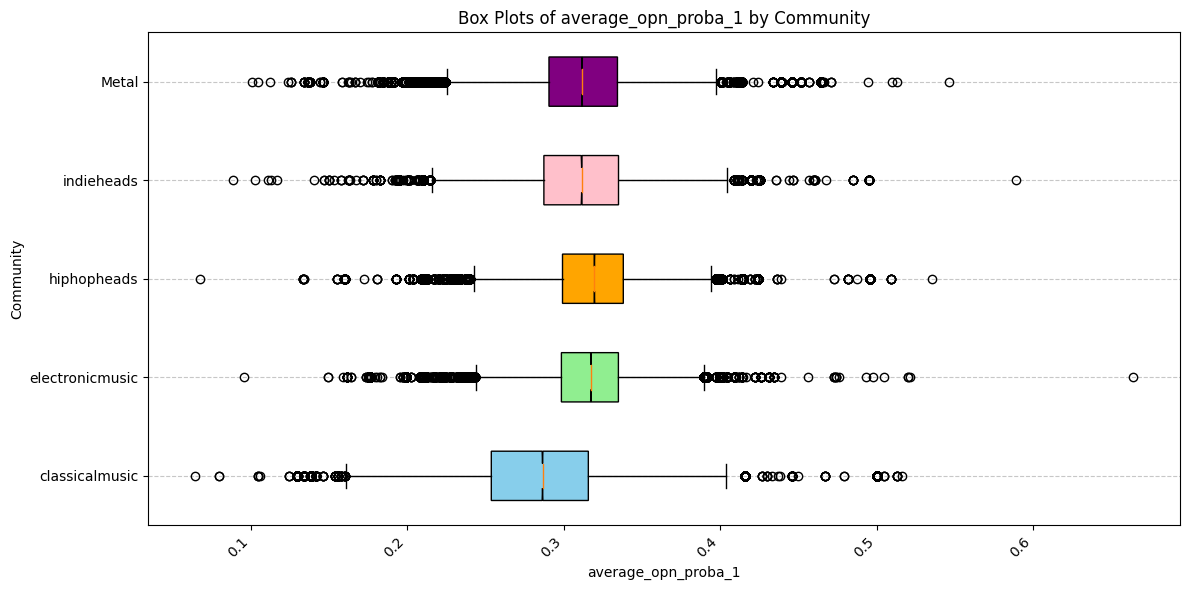

In [14]:
import pandas as pd
import matplotlib.pyplot as plt


def draw_proba_box_plot(class_name: str):
    plt.figure(figsize=(12, 6))

    bp = plt.boxplot(
        [df[df["community"] == c][class_name]
            for c in df["community"].unique()],
        notch=True,
        vert=False,
        labels=df["community"].unique(),
        patch_artist=True,
    )

    for box, color in zip(
        bp["boxes"], ["skyblue", "lightgreen", "orange", "pink", "purple"]
    ):
        box.set_facecolor(color)

    plt.xlabel(class_name)
    plt.ylabel("Community")
    plt.title(f"Box Plots of {class_name} by Community")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


draw_proba_box_plot("average_opn_proba_0")
draw_proba_box_plot("average_opn_proba_1")

In [21]:
# df.to_csv('mini_reddit_data_vectorized.csv', index=False)
df.to_pickle('mini_reddit_data_vectorized.pkl')


In [23]:
print("Example of the dataframe we have now:")
df.head()

Example of the dataframe we have now:


,community,user_name,user_texts,#_of_long_texts,vector,OPN_proba,average_opn_proba_0,average_opn_proba_1
0,classicalmusic,Radaxen,I remember doing this with WC3 Dota 1 Lifestea...,339,"[-0.09979952, 0.07815618, -0.006864944, 0.0918...","[[0.7617520430655333, 0.23824795693446665]]",0.707808,0.292192
1,classicalmusic,Radaxen,Why not? Though there's no AD in League. I ki...,339,"[-0.061279267, -0.03195634, -0.028046045, -0.0...","[[0.8164201826164899, 0.1835798173835101]]",0.707808,0.292192
2,classicalmusic,Radaxen,"Haha I was kind of joking. That aside, why mos...",339,"[-0.044217307, 0.05339438, -0.04739361, -0.068...","[[0.7133868303206266, 0.28661316967937345]]",0.707808,0.292192
3,classicalmusic,Radaxen,"Mana is often a less limiting factor, unless y...",339,"[0.006160024, -0.015307949, -0.02807415, -0.03...","[[0.6732404176899773, 0.32675958231002267]]",0.707808,0.292192
4,classicalmusic,Radaxen,"It's first pick worthy, but late in first phas...",339,"[-0.039119493, -0.023535224, -0.049316537, -0....","[[0.7115636906252298, 0.2884363093747701]]",0.707808,0.292192
